In [27]:
import json
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import ttest_rel
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
pio.renderers.default = 'svg'

In [28]:
pd.set_option('display.max_rows', None)

In [29]:
orig_df = pd.read_json('var_results/data_for_modeling.json')
orig_df = orig_df.sort_values(by=['Test set average cross-entropy'])
orig_df

,Test set perplexity,Test set average cross-entropy,Entropy,Distribution,Uni- or bigram,Vocab size,Softmax,Model type,Embedding size
92,1.471989,0.386615,2.302584,manual,unigrams,8193,False,lstm,256
99,1.472562,0.387004,2.302584,manual,unigrams,8193,False,trf,256
89,1.481061,0.392758,2.302584,manual,unigrams,8193,False,lstm,64
95,1.489251,0.398274,2.302584,manual,unigrams,8193,False,trf,64
90,1.621255,0.483200,2.303436,manual,unigrams,283,False,lstm,64
100,1.621907,0.483602,2.303436,manual,unigrams,283,False,trf,64
103,1.622420,0.483919,2.303436,manual,unigrams,283,False,trf,256
101,1.622714,0.484100,2.303436,manual,unigrams,283,False,lstm,256
102,2.081511,0.733094,2.304027,manual,unigrams,60,False,trf,64
93,2.082514,0.733576,2.304027,manual,unigrams,60,False,trf,256


# Curve fitting

In [30]:
# curve fitting
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def linear(x, a, b):
    return a * x + b

def combine_attrs(list1, list2):
    list1 = list1.tolist()
    list2 = list2.tolist()
    return [str(list1[i]) + ', ' + str(list2[i]) for i in range(len(list1))]

entropy = orig_df['Entropy']
test_set_perplexity = orig_df['Test set perplexity']
test_set_avg_cross_entropy = orig_df['Test set average cross-entropy']
dist = orig_df['Distribution']
uni_or_bi = orig_df['Uni- or bigram']
vocab_size = orig_df['Vocab size']
softmax = orig_df['Softmax']
model_type = orig_df['Model type']
embd_size = orig_df['Embedding size']

x_ent = np.linspace(min(entropy), max(entropy), 100)

ppl_vs_ent = curve_fit(exponential, entropy, test_set_perplexity)

y_ppl = exponential(x_ent, *ppl_vs_ent[0])

ce_vs_ent = curve_fit(linear, entropy, test_set_avg_cross_entropy)

y_ce = linear(x_ent, *ce_vs_ent[0])

ppl_fit = go.Scatter(
    x=x_ent,
    y=y_ppl,
    mode='lines',
    name=f'{ppl_vs_ent[0][0]:.2f} * exp({ppl_vs_ent[0][1]:.2f} * x) + {ppl_vs_ent[0][2]:.2f}'
)

ce_fit = go.Scatter(
    x=x_ent,
    y=y_ce,
    mode='lines',
    name=f'{ce_vs_ent[0][0]:.2f} * x + {ce_vs_ent[0][1]:.2f}'
)

y_equals_x = go.Scatter(
    x=x_ent,
    y=x_ent,
    mode='lines',
    name='Theoretical limit',
    marker=dict(color='red')
)

default_colors = plotly.colors.qualitative.Plotly
next_color = default_colors[13 % len(default_colors)]
ppl_fit.update(marker_color=next_color)
ce_fit.update(marker_color=next_color)
print()

# R^2

In [31]:
residuals = test_set_avg_cross_entropy - linear(np.array(entropy), *ce_vs_ent[0])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((test_set_avg_cross_entropy - np.mean(test_set_avg_cross_entropy))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'Overall R^2: {r_squared}')

Overall R^2: 0.984227875005013


# Plots

In [32]:
legend_dict = dict(
    orientation='h',
    y=-0.15,
)

marker_dict = dict(
    size=12,
    opacity=0.5,
)

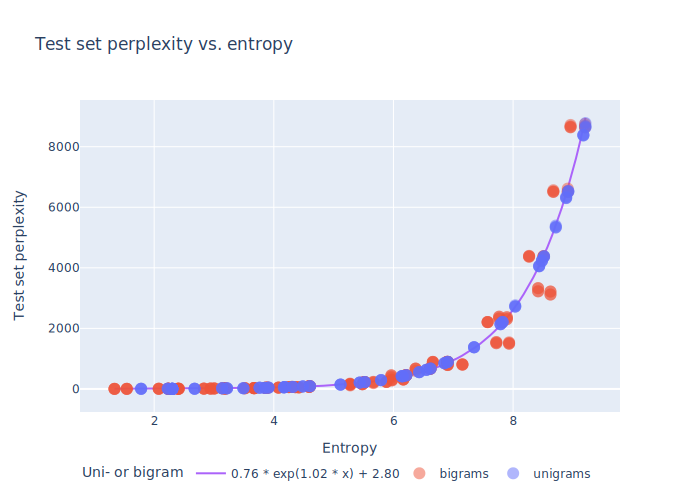

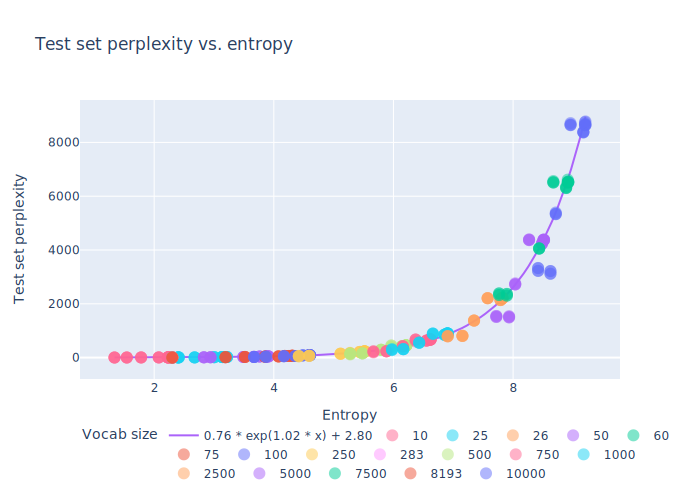

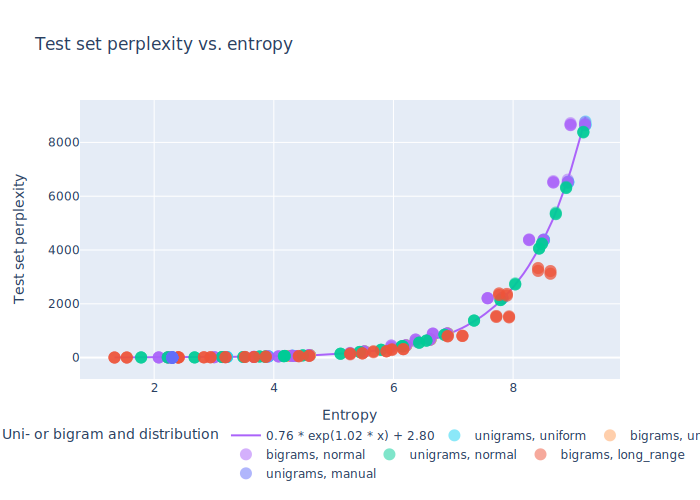

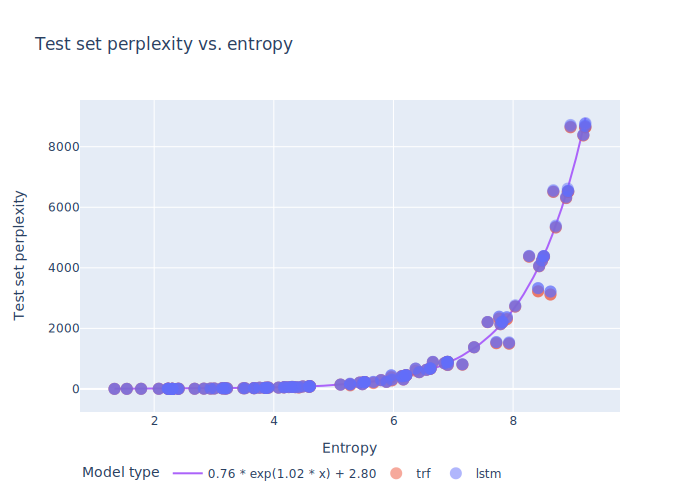

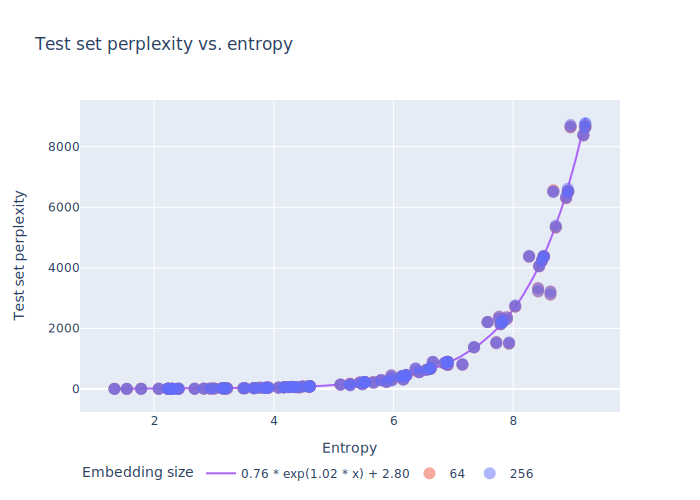

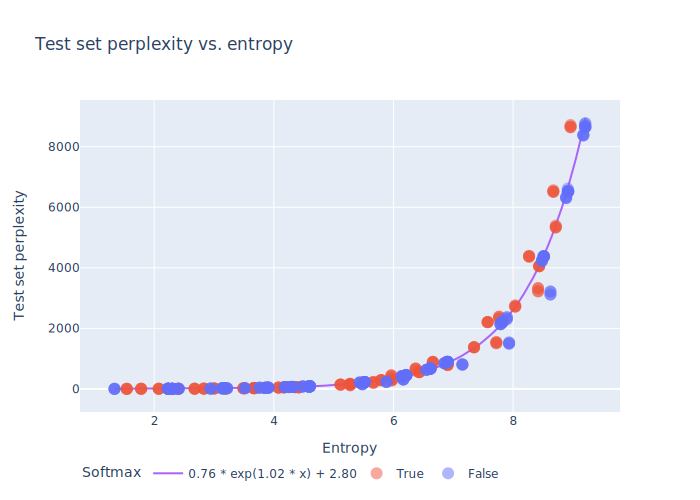

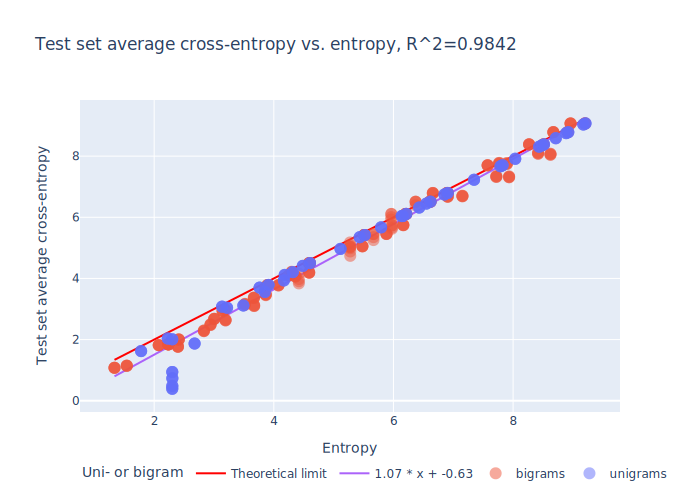

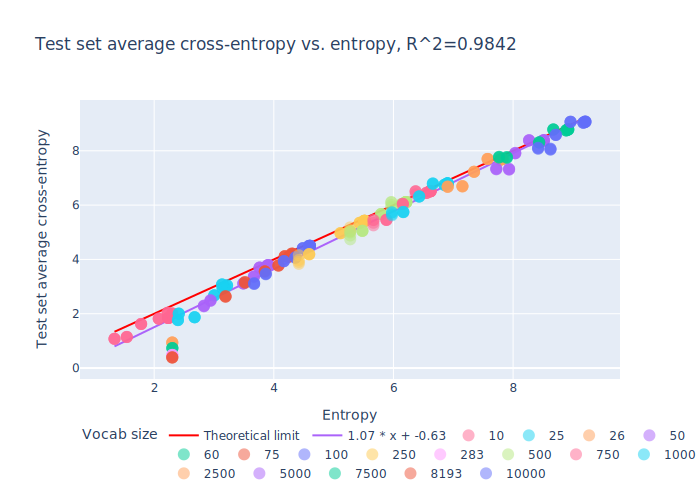

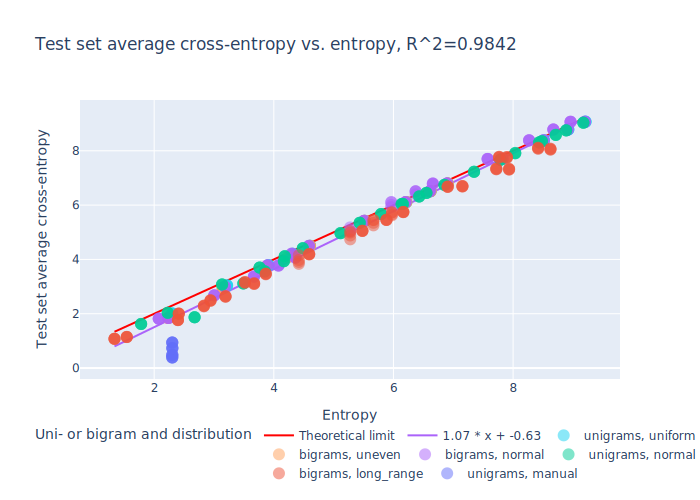

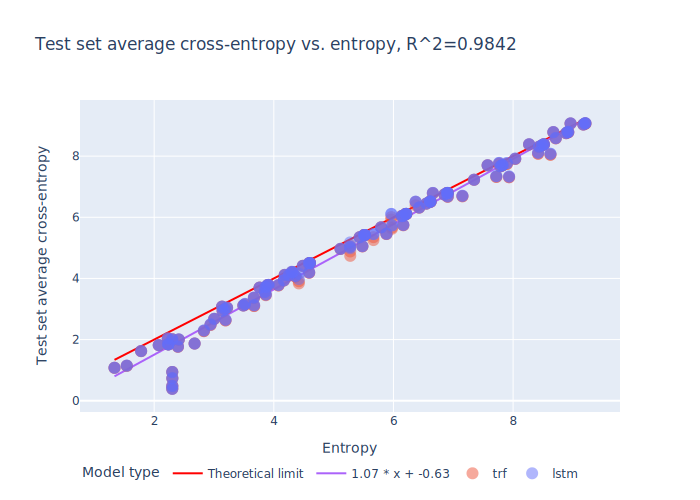

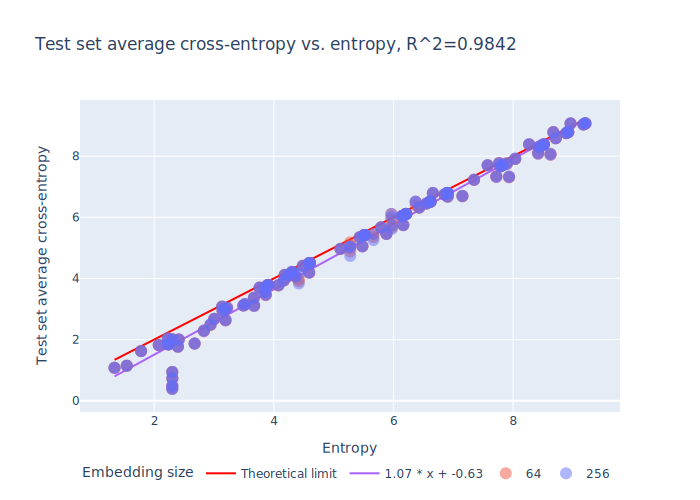

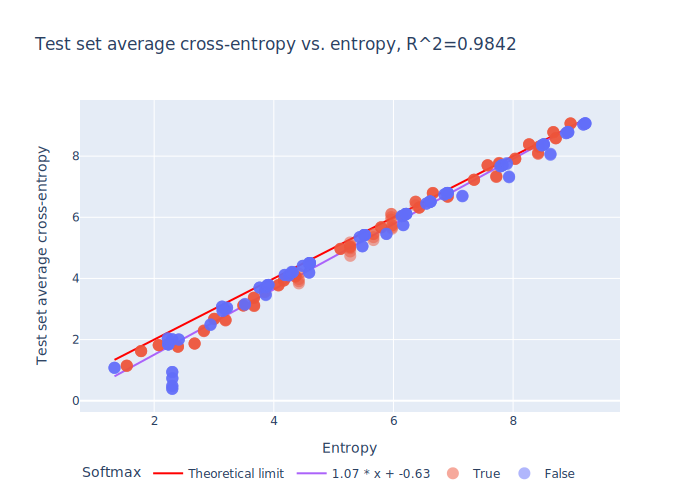

In [33]:
fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Uni- or bigram'},
    color=uni_or_bi,
    hover_data={'Vocab size': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi.html')
pio.write_image(fig, 'plots/uni_or_bi.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Vocab size'},
    color=[str(x) for x in vocab_size],
    category_orders={'color': reversed([str(x) for x in sorted(vocab_size)])},
    hover_data={'Uni- or bigram': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/vocab.html')
pio.write_image(fig, 'plots/vocab.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Uni- or bigram and distribution'},
    color=combine_attrs(uni_or_bi, dist),
    hover_data={'Vocab size': True, 'Softmax': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi_dist.html')
pio.write_image(fig, 'plots/uni_or_bi_dist.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Model type'},
    color='Model type',
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/model_type.html')
pio.write_image(fig, 'plots/model_type.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Embedding size'},
    color=[str(x) for x in embd_size],
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/embd_size.html')
pio.write_image(fig, 'plots/embd_size.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Softmax'},
    color='Softmax',
    hover_data={'Vocab size': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/softmax.html')
pio.write_image(fig, 'plots/softmax.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Uni- or bigram'},
    color='Uni- or bigram',
    hover_data={'Vocab size': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi_ce.html')
pio.write_image(fig, 'plots/uni_or_bi_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Vocab size'},
    color=[str(x) for x in vocab_size],
    category_orders={'color': reversed([str(x) for x in sorted(vocab_size)])},
    hover_data={'Uni- or bigram': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/vocab_ce.html')
pio.write_image(fig, 'plots/vocab_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Uni- or bigram and distribution'},
    color=combine_attrs(uni_or_bi, dist),
    hover_data={'Vocab size': True, 'Softmax': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi_dist_ce.html')
pio.write_image(fig, 'plots/uni_or_bi_dist_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Model type'},
    color='Model type',
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/model_type_ce.html')
pio.write_image(fig, 'plots/model_type_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Embedding size'},
    color=[str(x) for x in embd_size],
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/embd_size_ce.html')
pio.write_image(fig, 'plots/embd_size_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Softmax'},
    color='Softmax',
    hover_data={'Vocab size': True, 'Embedding size': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/softmax_ce.html')
pio.write_image(fig, 'plots/softmax_ce.pdf')
fig.show()

# Linear models

In [34]:
def encode_and_fit(df_arg):
    
    df = df_arg.copy()
    
    enc = OrdinalEncoder()
    scaler = StandardScaler()
    try:
        df['Distribution'] = enc.fit_transform(df[['Distribution']])
    except:
        pass
    try:
        df['Uni- or bigram'] = enc.fit_transform(df[['Uni- or bigram']])
    except:
        pass
    try:
        df['Softmax'] = enc.fit_transform(df[['Softmax']])
    except:
        pass
    try:
        df['Model type'] = enc.fit_transform(df[['Model type']])
    except:
        pass
    for col in df.columns:
        if col not in ['Distribution', 'Uni- or bigram', 'Softmax', 'Model type', 'Test set perplexity']:
            df[col] = scaler.fit_transform(df[[col]])
    
    reg = sm.OLS(
        df['Test set average cross-entropy'],
        sm.add_constant(df.drop(columns=['Test set average cross-entropy', 'Test set perplexity']))
    )
    res = reg.fit()
    print(res.summary2())
    print('\n\n\n')
    return res

In [35]:
for var in ['Entropy', 'Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']:
    print('independent variable:', var)
    res = encode_and_fit(orig_df[[var, 'Test set average cross-entropy', 'Test set perplexity']])

independent variable: Entropy
                        Results: Ordinary least squares
Model:              OLS                            Adj. R-squared:     0.984    
Dependent Variable: Test set average cross-entropy AIC:                -541.6398
Date:               2025-03-08 16:05               BIC:                -533.5784
No. Observations:   416                            Log-Likelihood:     272.82   
Df Model:           1                              F-statistic:        2.583e+04
Df Residuals:       414                            Prob (F-statistic): 0.00     
R-squared:          0.984                          Scale:              0.015848 
-------------------------------------------------------------------------------------
              Coef.       Std.Err.         t          P>|t|        [0.025      0.975]
-------------------------------------------------------------------------------------
const        -0.0000        0.0062       -0.0000      1.0000      -0.0121      0.0121
Ent

In [36]:
vars = ['Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']

for var in vars:
    for unique_val in orig_df[var].unique():
        print('data subset:', var, '=', unique_val)
        independent_vars = vars.copy()
        independent_vars.remove(var)
        if var == 'Distribution':
            if unique_val in ('manual', 'long_range'):
                independent_vars.remove('Uni- or bigram')
            if unique_val in ('manual', 'uniform', 'uneven'):
                independent_vars.remove('Softmax')
        res = encode_and_fit(orig_df[orig_df[var] == unique_val][independent_vars + ['Test set average cross-entropy', 'Test set perplexity']])

data subset: Distribution = manual
                       Results: Ordinary least squares
Model:              OLS                            Adj. R-squared:     0.328  
Dependent Variable: Test set average cross-entropy AIC:                43.4775
Date:               2025-03-08 16:05               BIC:                46.5679
No. Observations:   16                             Log-Likelihood:     -17.739
Df Model:           3                              F-statistic:        3.440  
Df Residuals:       12                             Prob (F-statistic): 0.0519 
R-squared:          0.462                          Scale:              0.71688
---------------------------------------------------------------------------------
                    Coef.     Std.Err.       t       P>|t|      [0.025     0.975]
---------------------------------------------------------------------------------
const              -0.0010      0.2993    -0.0035    0.9973    -0.6533     0.6512
Vocab size         -0.6799   

/home/share/apps/python/anaconda3-3.9/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



data subset: Vocab size = 8193
                        Results: Ordinary least squares
Model:              OLS                            Adj. R-squared:     0.784   
Dependent Variable: Test set average cross-entropy AIC:                6.8334  
Date:               2025-03-08 16:05               BIC:                4.9923  
No. Observations:   4                              Log-Likelihood:     -0.41670
Df Model:           2                              F-statistic:        6.434   
Df Residuals:       1                              Prob (F-statistic): 0.269   
R-squared:          0.928                          Scale:              0.28845 
----------------------------------------------------------------------------------
                      Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
----------------------------------------------------------------------------------
const                -0.3093      0.3798    -0.8145    0.5649    -5.1348    4.5161
Distribution         

/home/share/apps/python/anaconda3-3.9/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 4 samples were given.

/home/share/apps/python/anaconda3-3.9/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 4 samples were given.

/home/share/apps/python/anaconda3-3.9/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 4 samples were given.

/home/share/apps/python/anaconda3-3.9/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 4 samples were given.



                        Results: Ordinary least squares
Model:              OLS                            Adj. R-squared:     0.623   
Dependent Variable: Test set average cross-entropy AIC:                65.9888 
Date:               2025-03-08 16:05               BIC:                74.7832 
No. Observations:   32                             Log-Likelihood:     -26.994 
Df Model:           5                              F-statistic:        11.23   
Df Residuals:       26                             Prob (F-statistic): 7.65e-06
R-squared:          0.684                          Scale:              0.38942 
----------------------------------------------------------------------------------
                     Coef.     Std.Err.       t       P>|t|      [0.025     0.975]
----------------------------------------------------------------------------------
const               -0.5620      0.2535    -2.2174    0.0355    -1.0830    -0.0410
Distribution         0.6966      0.1454     4.7919  

# Spearman rhos

In [37]:
orig_df[['Entropy', 'Vocab size', 'Test set average cross-entropy']].corr(method='spearman')

,Entropy,Vocab size,Test set average cross-entropy
Entropy,1.000000,0.930072,0.994800
Vocab size,0.930072,1.000000,0.908688
Test set average cross-entropy,0.994800,0.908688,1.000000


# Mixed Effects

In [38]:
formula = "Q('Test set average cross-entropy') ~ Q('Entropy') + Q('Distribution') + Q('Uni- or bigram') + Q('Vocab size') + Q('Softmax') + Q('Model type') + Q('Embedding size') - 1"

In [39]:
model = smf.mixedlm(
    formula,
    data=orig_df,
    groups=orig_df['Entropy'] 
).fit()
print(model.summary())

                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('Test set average cross-entropy')
No. Observations: 416     Method:             REML                               
No. Groups:       104     Scale:              0.0006                             
Min. group size:  4       Log-Likelihood:     670.2246                           
Max. group size:  4       Converged:          Yes                                
Mean group size:  4.0                                                            
----------------------------------------------------------------------------------
                                  Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
----------------------------------------------------------------------------------
Q('Distribution')[long_range]     -0.595     0.049  -12.087  0.000  -0.691  -0.498
Q('Distribution')[manual]         -1.677     0.074  -22.689  0.000  -1.822  -1.532
Q('Distribution')[normal]        

In [40]:
x = orig_df['Entropy']
y = orig_df['Test set average cross-entropy']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
orig_df['Entropy residual'] = model.resid

formula = "Q('Entropy residual') ~ Q('Distribution') + Q('Uni- or bigram') + Q('Vocab size') + Q('Softmax') + Q('Model type') + Q('Embedding size') - 1"

model = smf.mixedlm(
    formula,
    data=orig_df,
    groups=orig_df['Entropy']
).fit()
print(model.summary())

                   Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Q('Entropy residual')
No. Observations:     416       Method:               REML                 
No. Groups:           104       Scale:                0.0006               
Min. group size:      4         Log-Likelihood:       671.2819             
Max. group size:      4         Converged:            Yes                  
Mean group size:      4.0                                                  
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Q('Distribution')[long_range]   -0.058    0.031  -1.874 0.061 -0.118  0.003
Q('Distribution')[manual]       -1.077    0.075 -14.452 0.000 -1.223 -0.931
Q('Distribution')[normal]        0.189    0.031   6.148 0.000  0.129  0.249
Q('Distribution')[uneven]      

# Paired test - effect of long-range dependencies

In [41]:
normal_bigrams = orig_df[orig_df['Uni- or bigram'] == 'bigrams']
normal_bigrams = normal_bigrams[normal_bigrams['Distribution'] == 'normal']
normal_bigrams = normal_bigrams.sort_values(by=['Vocab size', 'Softmax', 'Model type', 'Embedding size']).reset_index(drop=True)
normal_bigrams = normal_bigrams[['Test set average cross-entropy', 'Entropy', 'Distribution']]
normal_bigrams = normal_bigrams.rename(columns={'Test set average cross-entropy': 'ce', 'Entropy': 'ent', 'Distribution': 'dist'})
normal_bigrams['pair_idx'] = normal_bigrams.index
normal_bigrams.shape, normal_bigrams.head()

((104, 4),
          ce       ent    dist  pair_idx
 0  1.841479  2.239160  normal         0
 1  1.841434  2.239160  normal         1
 2  1.842814  2.239160  normal         2
 3  1.845113  2.239160  normal         3
 4  1.818720  2.076645  normal         4)

In [42]:
long_range_bigrams = orig_df[orig_df['Uni- or bigram'] == 'bigrams']
long_range_bigrams = long_range_bigrams[long_range_bigrams['Distribution'] == 'long_range']
long_range_bigrams = long_range_bigrams.sort_values(by=['Vocab size', 'Softmax', 'Model type', 'Embedding size']).reset_index(drop=True)
long_range_bigrams = long_range_bigrams[['Test set average cross-entropy', 'Entropy', 'Distribution']]
long_range_bigrams = long_range_bigrams.rename(columns={'Test set average cross-entropy': 'ce', 'Entropy': 'ent', 'Distribution': 'dist'})
long_range_bigrams['pair_idx'] = long_range_bigrams.index
long_range_bigrams.shape, long_range_bigrams.head()

((104, 4),
          ce       ent        dist  pair_idx
 0  1.077951  1.336951  long_range         0
 1  1.078232  1.336951  long_range         1
 2  1.074619  1.336951  long_range         2
 3  1.076578  1.336951  long_range         3
 4  1.148354  1.542236  long_range         4)

In [43]:
paired_test_df = pd.concat([normal_bigrams, long_range_bigrams], axis=0)
paired_test_df['deviation'] = paired_test_df['ent'] - paired_test_df['ce']
paired_test_df['dist'] = pd.Categorical(paired_test_df['dist'], categories=['normal', 'long_range'], ordered=True)
paired_test_df.shape, paired_test_df.head()

((208, 5),
          ce       ent    dist  pair_idx  deviation
 0  1.841479  2.239160  normal         0   0.397680
 1  1.841434  2.239160  normal         1   0.397725
 2  1.842814  2.239160  normal         2   0.396345
 3  1.845113  2.239160  normal         3   0.394047
 4  1.818720  2.076645  normal         4   0.257925)

In [44]:
model = smf.mixedlm(
    "deviation ~ dist - 1",
    data=paired_test_df,
    groups=paired_test_df['pair_idx']
)
res = model.fit()
print(res.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  deviation
No. Observations:  208      Method:              REML     
No. Groups:        104      Scale:               0.0106   
Min. group size:   2        Log-Likelihood:      109.3966 
Max. group size:   2        Converged:           Yes      
Mean group size:   2.0                                    
----------------------------------------------------------
                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
dist[normal]     0.102    0.015  6.899 0.000  0.073  0.131
dist[long_range] 0.399    0.015 26.855 0.000  0.370  0.428
Group Var        0.012    0.034                           



In [45]:
normal_bigrams['deviation'] = normal_bigrams['ent'] - normal_bigrams['ce']
normal_bigrams.shape, normal_bigrams.head()

((104, 5),
          ce       ent    dist  pair_idx  deviation
 0  1.841479  2.239160  normal         0   0.397680
 1  1.841434  2.239160  normal         1   0.397725
 2  1.842814  2.239160  normal         2   0.396345
 3  1.845113  2.239160  normal         3   0.394047
 4  1.818720  2.076645  normal         4   0.257925)

In [46]:
long_range_bigrams['deviation'] = long_range_bigrams['ent'] - long_range_bigrams['ce']
long_range_bigrams.shape, long_range_bigrams.head()

((104, 5),
          ce       ent        dist  pair_idx  deviation
 0  1.077951  1.336951  long_range         0   0.259001
 1  1.078232  1.336951  long_range         1   0.258719
 2  1.074619  1.336951  long_range         2   0.262333
 3  1.076578  1.336951  long_range         3   0.260373
 4  1.148354  1.542236  long_range         4   0.393882)

In [47]:
ttest_rel(
    normal_bigrams['deviation'],
    long_range_bigrams['deviation']
)

Ttest_relResult(statistic=-20.704150217101013, pvalue=1.7026635595139926e-38)

# Heatmaps to show dists

In [48]:
fnames_100_nosoftmax = glob.glob('var_results/*_50_nosoftmax.json')
fnames_100_softmax = glob.glob('var_results/*_50_softmax.json')
jsons_100_nosoftmax = [
    json.load(open(f)) for f in fnames_100_nosoftmax
]
jsons_100_softmax = [
    json.load(open(f)) for f in fnames_100_softmax
]

manual = 'var_results/manual_unigrams_60_nosoftmax_manual_0.6.json'
manual_json = json.load(open(manual))

fnames = fnames_100_nosoftmax + fnames_100_softmax + [manual]
tables = [j['table'] for j in jsons_100_nosoftmax] + [j['table'] for j in jsons_100_softmax] + [manual_json['table']]
entropies = [j['entropy'] for j in jsons_100_nosoftmax] + [j['entropy'] for j in jsons_100_softmax] + [manual_json['entropy']]

del jsons_100_nosoftmax
del jsons_100_softmax

In [49]:
fnames[0]

'var_results/long_range_bigrams_50_nosoftmax.json'

In [50]:
def plot_heatmap(fname, data, entropy):
    save_name = fname.split('/')[-1].replace('.json', '.png')
    title = fname.split('/')[-1].replace('.json', '').replace('_50_', ', ').replace(', nosoftmax', '').replace('_', ' ')
    title = title[0].upper() + title[1:]
    title += f', entropy={entropy:.4f}'
    if 'manual' in title:
        title = f'Manual unigrams, special token probability=0.6, entropy={entropy:.4f}'
    # plt.figure()
    # sns.heatmap(data, cmap='coolwarm', square=True)
    # plt.title(title)
    # plt.savefig('heatmaps/' + save_name)
    # plt.show()
    # plt.close()
    fig = px.imshow(
        data,
        title=title,
        color_continuous_scale='RdBu_r'
    )
    fig.show()
    fig.write_html('heatmaps/' + save_name.replace('.png', '.html'))
    pio.write_image(fig, 'heatmaps/' + save_name.replace('.png', '.pdf'))

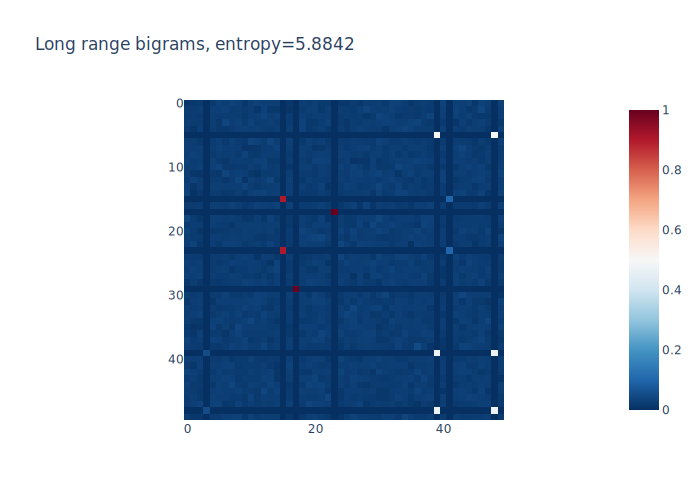

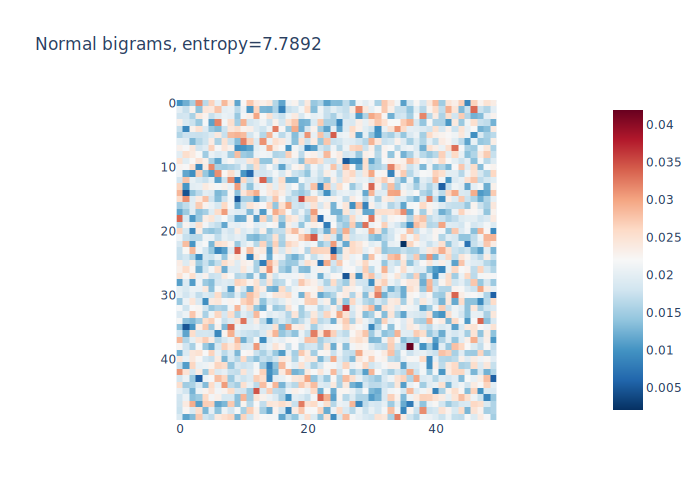

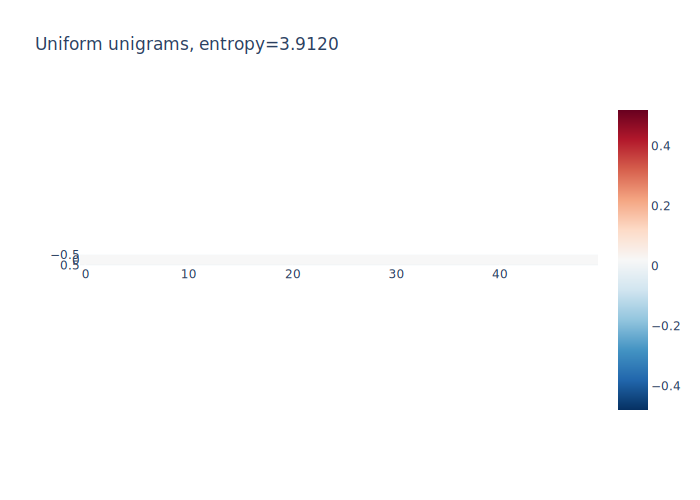

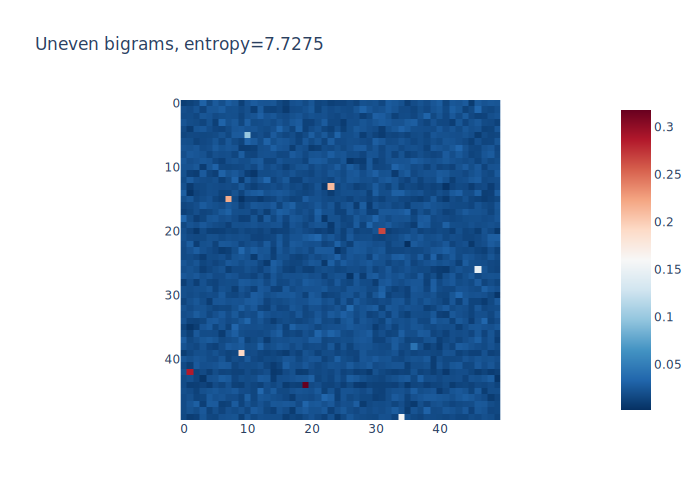

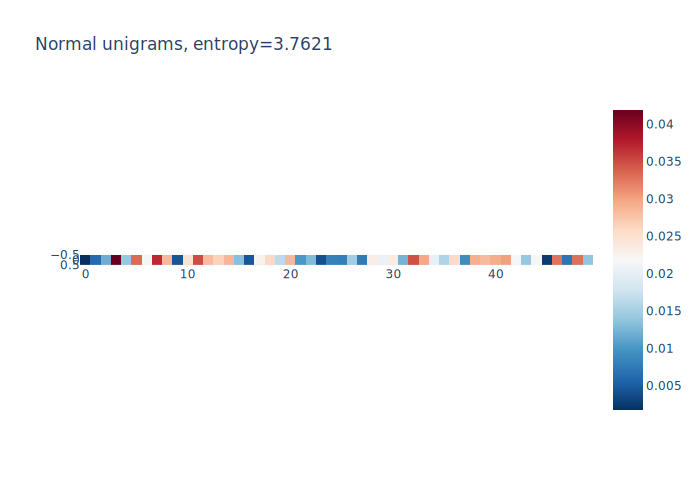

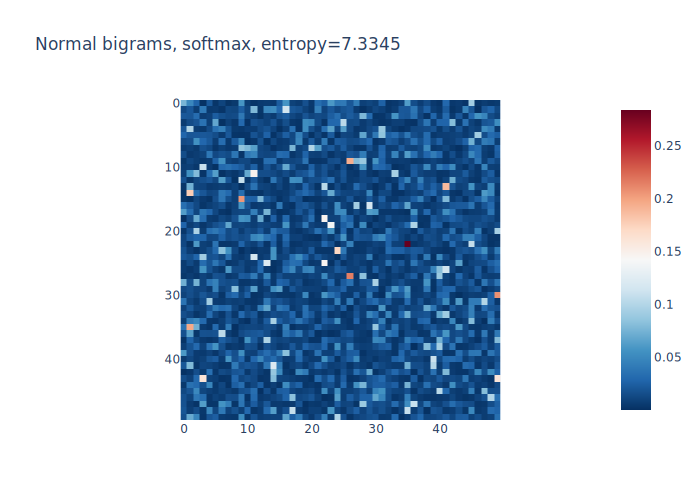

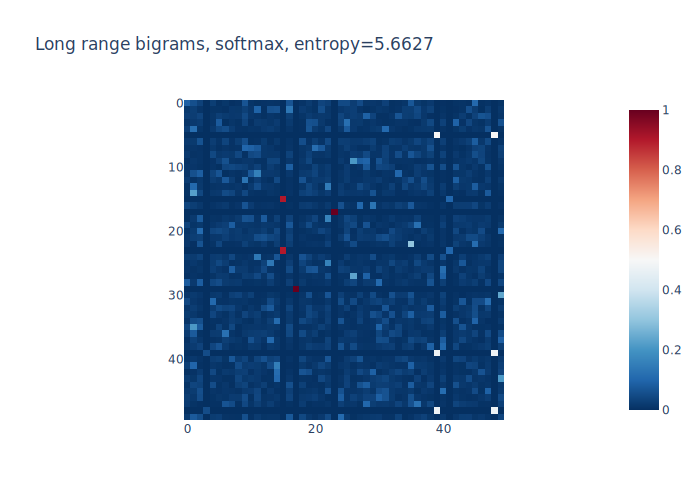

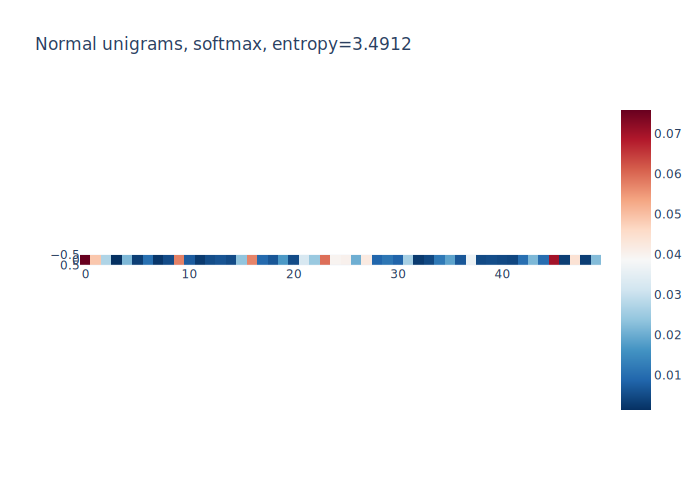

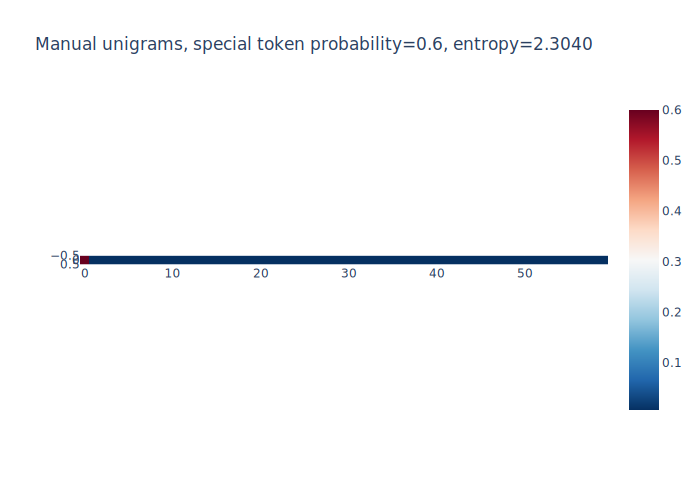

In [51]:
for fname, table, entropy in zip(fnames, tables, entropies):
    if 'unigrams' in fname:
        table = [table]
    plot_heatmap(fname, table, entropy)